In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [4]:
import os
# Uncomment for CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import utils.probabilistic_drnn_model
import utils.visualization
import utils.tf_helpers
import h5py
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sacred

tf.__version__

'2.1.0'

In [6]:
hd = h5py.File('../../DQN/car_racing.hdf5', 'r')

In [7]:
hd.keys()

<KeysViewHDF5 ['action', 'observation', 'reward']>

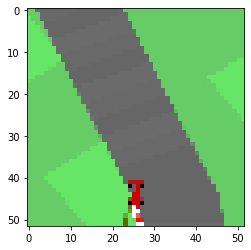

In [8]:
scale = 0.15
resize = lambda f: cv2.resize(f, (int(f.shape[1] * scale), int(f.shape[0] *  scale)))

vids = hd['observation'][:2, :256, :350, 125:350 + 125]
vids = np.array([[resize(f) for f in vid] for vid in vids])

plt.imshow(vids[0, 120])

In [9]:
hd['observation'][0, 0].max() / 255

1.0

In [10]:
MIN_REWARD = hd['reward'][()].min()
MAX_REWARD = hd['reward'][()].max()

MIN_REWARD, MAX_REWARD

(-0.1, 8.788889)

In [11]:
ex = sacred.Experiment(name='DRNN Car Racing 1', interactive=True)

In [12]:
hd['reward'].shape

(100, 1000)

In [13]:
@ex.capture
def make_dataset(bs, W, H, SEQ_LEN):
    resize = lambda f, s: cv2.resize(f, (int(f.shape[1] * s), int(f.shape[0] *  s)))

    print('>>> Start preprocessing data', flush=True)

    actions = hd['action']
    rewards = hd['reward']
    observations = hd['observation']

    # make frames square
    # cut bottom strip
    # resize
    scale = 0.15 # percentage of original size
    o = observations[:, :SEQ_LEN, :350, 125:350 + 125]
    o = np.array([[resize(f, scale) for f in vid] for vid in o])
    o = o / 255.0

    a = actions[:, :SEQ_LEN]
    r = rewards[:, :SEQ_LEN]
    r = (r - MIN_REWARD) / (MAX_REWARD - MIN_REWARD)

    print('>>> Data preprocessing end', flush=True)

    def data_input():
        for i in range(len(o)):
            yield (a[i],), (o[i], r[i])

    return tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32,), (tf.float32, tf.float32)),
        # the output shapes is required because of - https://github.com/tensorflow/tensorflow/issues/24520
        output_shapes=((tf.TensorShape((SEQ_LEN, 3)),), (tf.TensorShape((SEQ_LEN, W, H, 3)), tf.TensorShape((SEQ_LEN)))),
    ).repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
list(make_dataset(100, 52, 52, 2).take(1))[0][1][0].shape

>>> Start preprocessing data
>>> Data preprocessing end


TensorShape([100, 2, 52, 52, 3])

In [15]:
def on_batch_begin(model, input_generator):
    def sampler():
        X, Y = list(input_generator.take(1))[0]
        return X, Y[0]

    utils.visualization.plot_pairwise_frames(
        sampler=sampler,
        hypotheses=lambda x: model.net.predict(x)[0][0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [19]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
    should_preload_model,
):
    input_generator = make_dataset(bs=batch_size)

    #### Model
    model = utils.probabilistic_drnn_model.DRNN(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
        utils.tf_helpers.model_persistor(
            model,
            should_preload_model=should_preload_model,
            cp_file_name='cp-drnn-{epoch:0004d}-{loss:.5f}.hdf5'
        ),
        utils.tf_helpers.on_batch_begin(lambda: on_batch_begin(model, input_generator)),
        model.tb_callback,
    ]
    
    #### Training
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

In [20]:
@ex.config
def config():
    SEQ_LEN = 128
    W, H = 52, 52
    internal_size = 32
    batch_size = 32
    steps_per_epoch = 128
    lr = 0.005
    weight_decay = 0.0001
    should_preload_model = True

WARNING - DRNN Car Racing 1 - No observers have been added to this run
INFO - DRNN Car Racing 1 - Running command 'main'
INFO - DRNN Car Racing 1 - Started


>>> Start preprocessing data
>>> Data preprocessing end
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action (InputLayer)             [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
rnn_gru_gru1 (GRU)              (None, None, 32)     3552        action[0][0]                     
__________________________________________________________________________________________________
batch_norm_gru1 (BatchNormaliza (None, None, 32)     128         rnn_gru_gru1[0][0]               
__________________________________________________________________________________________________
space_to_batch_gru2 (Lambda)    (None, None, 32)     0           batch_norm_gru1[0][0]            
____________________________________

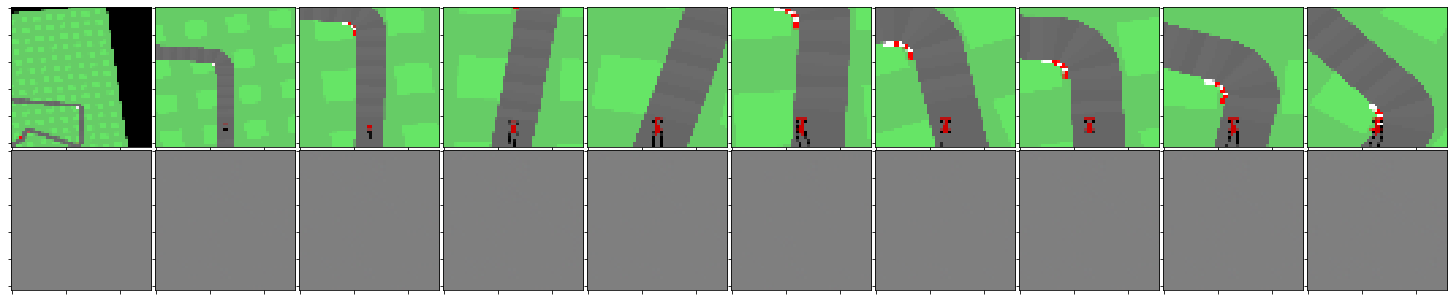

Epoch 1/2000
128/128 [==============================] - 18s 140ms/step - loss: 0.9150 - time_distributed_3_loss: 0.6587 - reward_dense2_loss: 0.2563 - val_loss: 0.9187 - val_time_distributed_3_loss: 0.6529 - val_reward_dense2_loss: 0.2658


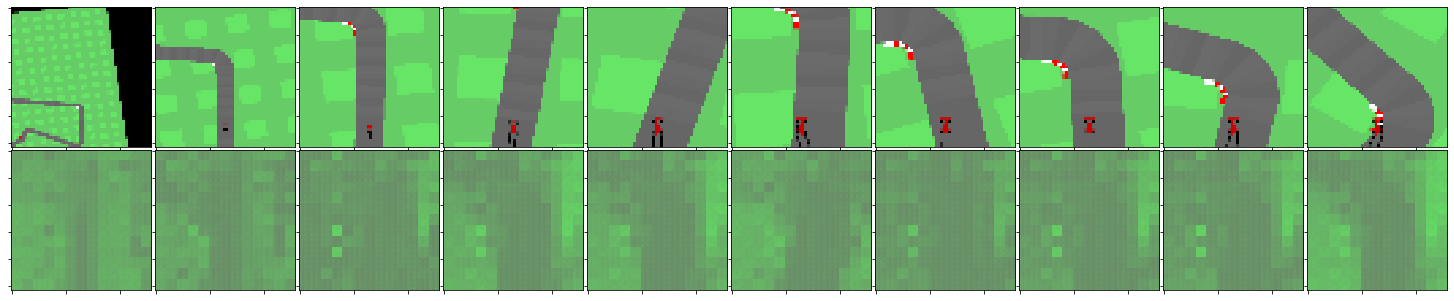

Epoch 2/2000
128/128 [==============================] - 14s 113ms/step - loss: 0.8717 - time_distributed_3_loss: 0.6443 - reward_dense2_loss: 0.2274 - val_loss: 0.8945 - val_time_distributed_3_loss: 0.6477 - val_reward_dense2_loss: 0.2468


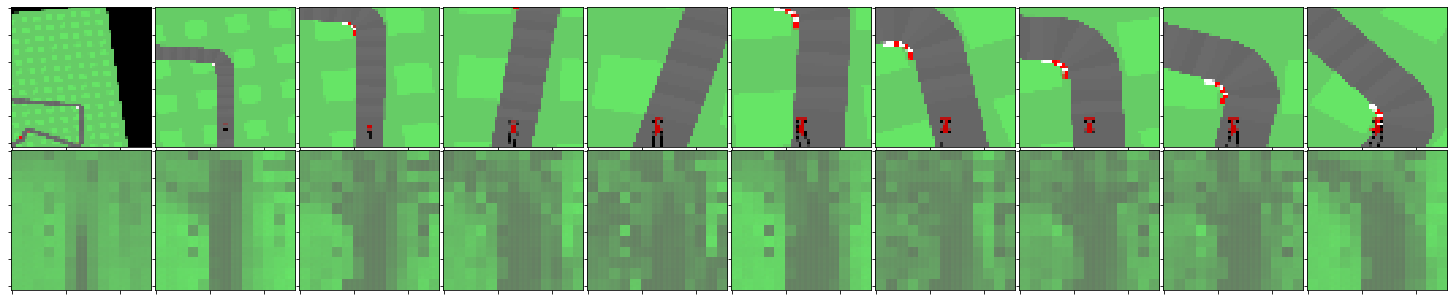

Epoch 3/2000
128/128 [==============================] - 14s 113ms/step - loss: 0.8565 - time_distributed_3_loss: 0.6411 - reward_dense2_loss: 0.2153 - val_loss: 0.8860 - val_time_distributed_3_loss: 0.6434 - val_reward_dense2_loss: 0.2426


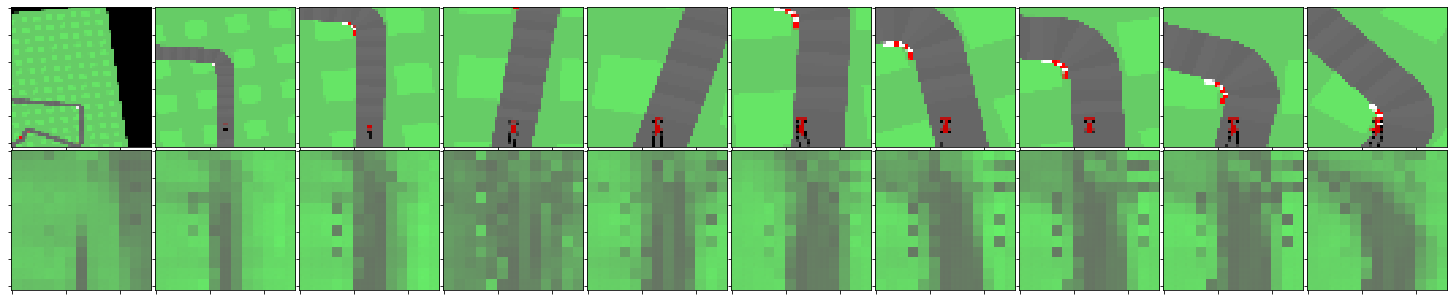

Epoch 4/2000
 97/128 [=====================>........] - ETA: 3s - loss: 0.8384 - time_distributed_3_loss: 0.6398 - reward_dense2_loss: 0.1986

In [ ]:
ex.run(config_updates={'should_preload_model': False})

In [ ]:
x = tf.random.uniform((2, 3, 13, 13, 3))

c = tf.keras.layers.Conv2DTranspose(2, (2, 2), strides=(2, 2))
x = tf.keras.layers.TimeDistributed(c)(x)
c = tf.keras.layers.Conv2DTranspose(2, (1, 1), strides=(2, 2), output_padding=(1, 1))
x = tf.keras.layers.TimeDistributed(c)(x)

x.shape